In [1]:
# load special jupyter notebook helpers
%matplotlib inline

# import libraries we'll use below
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = '/home/aca10131kr/datasets/01_eeg_fmri_data.h5'

# Load the data
with h5py.File(data_path, 'r') as f:
    eeg_data = np.array(f['eeg_train'][:])
    fmri_data = np.array(f['fmri_train'][:])

# Normalize the data
eeg_data = eeg_data / np.max(eeg_data)
fmri_data = fmri_data / np.max(fmri_data)

# Split the data into training and testing sets
eeg_train, eeg_test, fmri_train, fmri_test = train_test_split(eeg_data, fmri_data, test_size=0.2, random_state=42)

# Normalization
eeg_train = (eeg_train - np.min(eeg_train)) / (np.max(eeg_train) - np.min(eeg_train))
fmri_train = (fmri_train - np.min(fmri_train)) / (np.max(fmri_train) - np.min(fmri_train))
eeg_test = (eeg_test - np.min(eeg_test)) / (np.max(eeg_test) - np.min(eeg_test))
fmri_test = (fmri_test - np.min(fmri_test)) / (np.max(fmri_test) - np.min(fmri_test))

In [3]:
class EEGfMRIDataset(Dataset):
    def __init__(self, eeg_data, fmri_data):
        self.eeg_data = eeg_data
        self.fmri_data = fmri_data

    def __len__(self):
        return len(self.eeg_data)

    def __getitem__(self, idx):
        eeg = self.eeg_data[idx]
        fmri = self.fmri_data[idx]
        return eeg, fmri

# Create datasets and dataloaders
train_dataset = EEGfMRIDataset(torch.tensor(eeg_train, dtype=torch.float32), torch.tensor(fmri_train, dtype=torch.float32))
test_dataset = EEGfMRIDataset(torch.tensor(eeg_test, dtype=torch.float32), torch.tensor(fmri_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(64, 32, kernel_size=3, stride=2, padding=1),  # (B, 32, 32, 135, 5)
            nn.ReLU(True),
            nn.Conv3d(32, 16, kernel_size=3, stride=2, padding=1),  # (B, 16, 16, 68, 3)
            nn.ReLU(True),
            nn.Conv3d(16, 8, kernel_size=3, stride=2, padding=1),   # (B, 8, 8, 34, 2)
            nn.ReLU(True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 16, 16, 68, 3)
            nn.ReLU(True),
            nn.ConvTranspose3d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 32, 135, 5)
            nn.ReLU(True),
            nn.ConvTranspose3d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=(0, 1, 1)),  # (B, 64, 64, 269, 10)
            nn.Conv3d(64, 1, kernel_size=1),  # (B, 1, 64, 269, 10)
            nn.Upsample(size=(64, 64, 30), mode='trilinear', align_corners=True),  # (B, 1, 64, 64, 30)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        # print(f'Encoder output: {x.mean().item()}, {x.std().item()}')  # Debugging output
        x = self.decoder(x)
        # print(f'Decoder output: {x.mean().item()}, {x.std().item()}')  # Debugging output
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)

In [5]:
# Set loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Permute labels to match the shape of outputs
        labels = labels.permute(0, 4, 1, 2, 3)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Print shapes for debugging
        # print(f'outputs shape: {outputs.shape}')
        # print(f'labels shape: {labels.shape}')
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print('Finished Training')

Epoch [1/150], Loss: 0.0676
Epoch [2/150], Loss: 0.0234
Epoch [3/150], Loss: 0.0183
Epoch [4/150], Loss: 0.0174
Epoch [5/150], Loss: 0.0169
Epoch [6/150], Loss: 0.0166
Epoch [7/150], Loss: 0.0165
Epoch [8/150], Loss: 0.0161
Epoch [9/150], Loss: 0.0159
Epoch [10/150], Loss: 0.0157
Epoch [11/150], Loss: 0.0156
Epoch [12/150], Loss: 0.0155
Epoch [13/150], Loss: 0.0155
Epoch [14/150], Loss: 0.0150
Epoch [15/150], Loss: 0.0150
Epoch [16/150], Loss: 0.0148
Epoch [17/150], Loss: 0.0148
Epoch [18/150], Loss: 0.0147
Epoch [19/150], Loss: 0.0146
Epoch [20/150], Loss: 0.0146
Epoch [21/150], Loss: 0.0144
Epoch [22/150], Loss: 0.0144
Epoch [23/150], Loss: 0.0141
Epoch [24/150], Loss: 0.0139
Epoch [25/150], Loss: 0.0137
Epoch [26/150], Loss: 0.0140
Epoch [27/150], Loss: 0.0138
Epoch [28/150], Loss: 0.0133
Epoch [29/150], Loss: 0.0134
Epoch [30/150], Loss: 0.0129
Epoch [31/150], Loss: 0.0128
Epoch [32/150], Loss: 0.0125
Epoch [33/150], Loss: 0.0124
Epoch [34/150], Loss: 0.0121
Epoch [35/150], Loss: 0

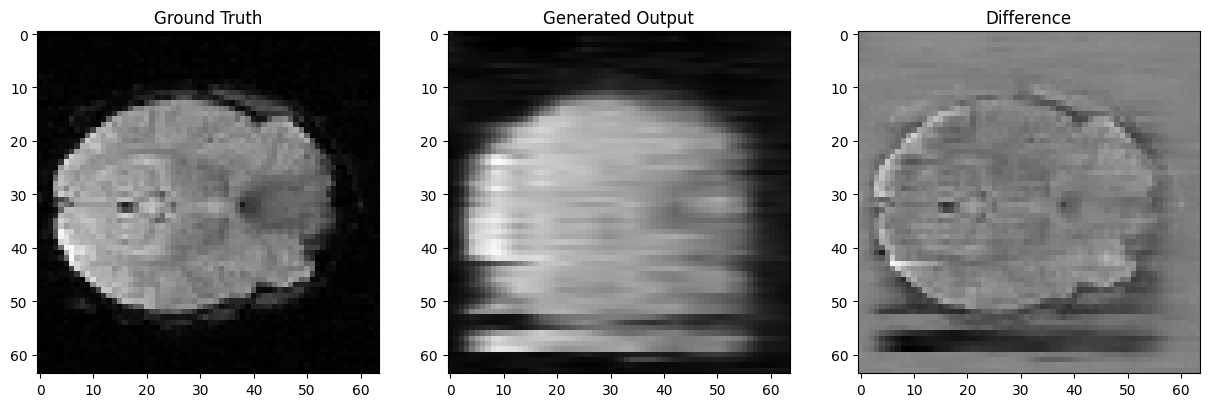

In [14]:
# Put the model in evaluation mode
model.eval()

# Get a batch of test inputs
test_batch = next(iter(test_loader))
inputs, labels = test_batch
inputs, labels = inputs.to(device), labels.to(device)

# Generate outputs
with torch.no_grad():
    outputs = model(inputs)

# Convert to NumPy arrays
inputs_np = inputs.cpu().numpy()
labels_np = labels.cpu().numpy()
outputs_np = outputs.cpu().numpy()

# Permute labels to match the shape of outputs
labels_np = np.transpose(labels_np, (0, 4, 1, 2, 3))

# Function to plot the data
def plot_comparison(labels, outputs, slice_idx, depth_idx):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Select a specific depth slice
    labels_slice = labels[slice_idx, 0, :, :, depth_idx]
    outputs_slice = outputs[slice_idx, 0, :, :, depth_idx]
    diff_slice = labels_slice - outputs_slice

    # Ensure the selected slices are 2D
    labels_slice = labels_slice if labels_slice.ndim == 2 else labels_slice[:, :, 0]
    outputs_slice = outputs_slice if outputs_slice.ndim == 2 else outputs_slice[:, :, 0]
    diff_slice = diff_slice if diff_slice.ndim == 2 else diff_slice[:, :, 0]

    axes[0].imshow(labels_slice, cmap='gray')
    axes[0].set_title('Ground Truth')

    axes[1].imshow(outputs_slice, cmap='gray')
    axes[1].set_title('Generated Output')

    axes[2].imshow(diff_slice, cmap='gray')
    axes[2].set_title('Difference')

    plt.show()

# Plot a comparison for a specific slice and depth
plot_comparison(labels_np, outputs_np, slice_idx=0, depth_idx=10)


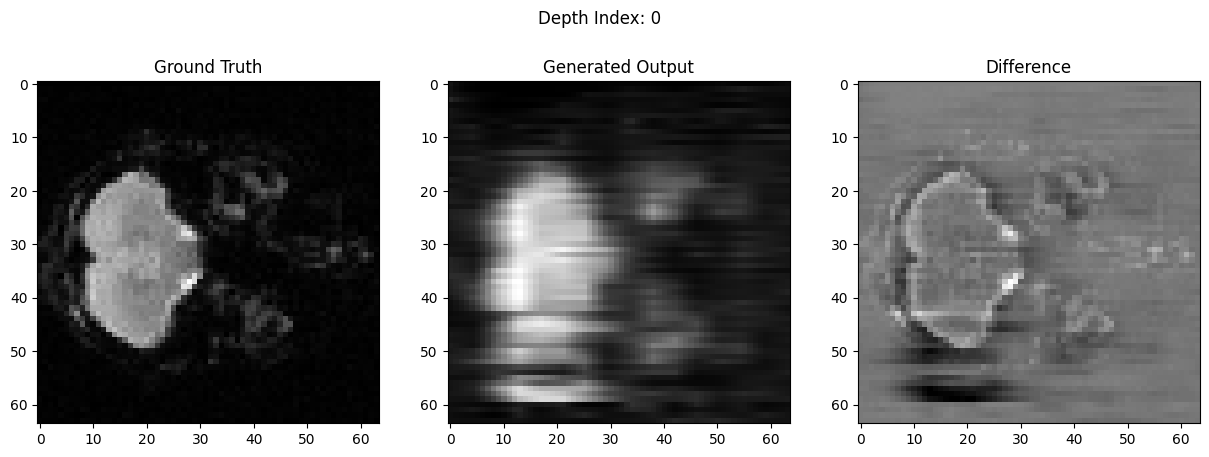

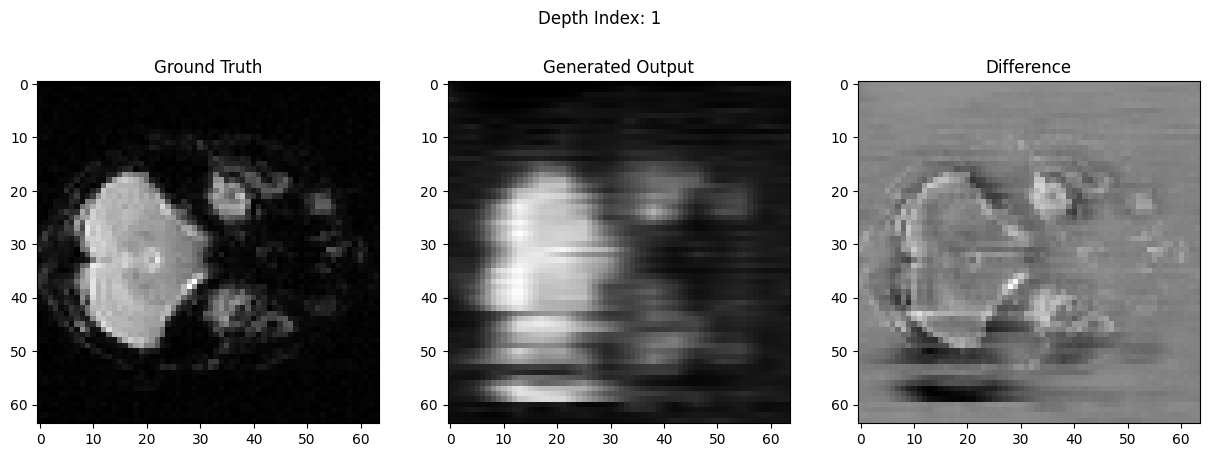

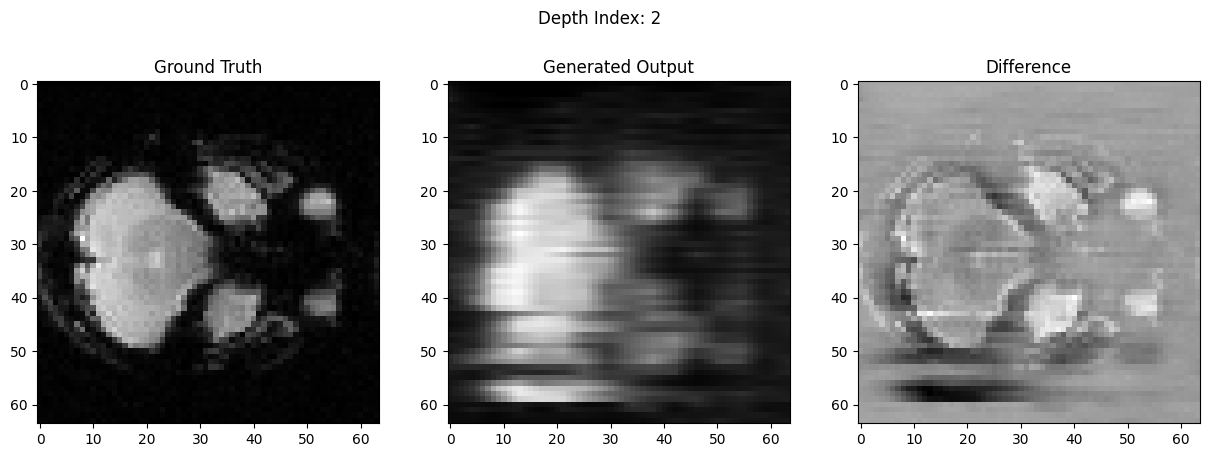

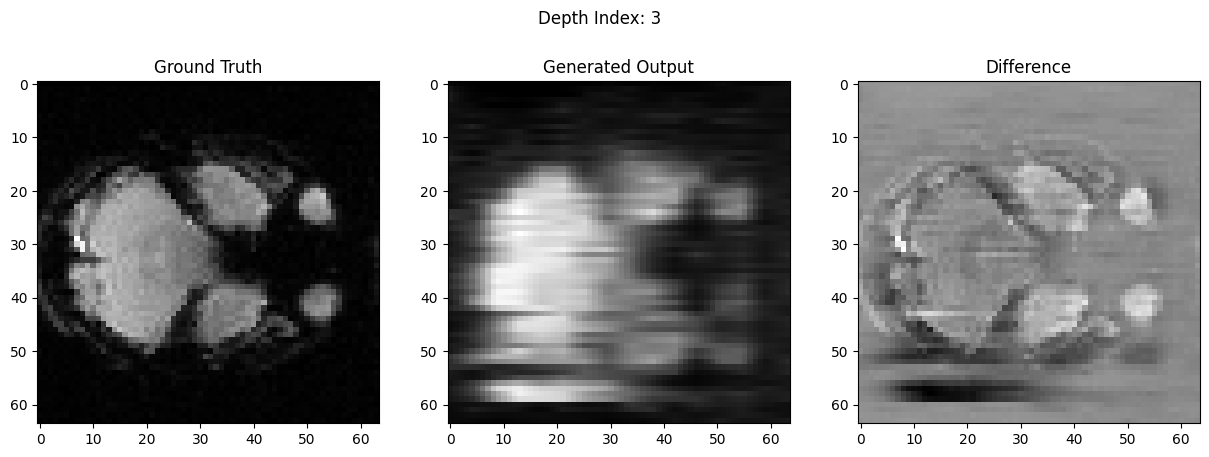

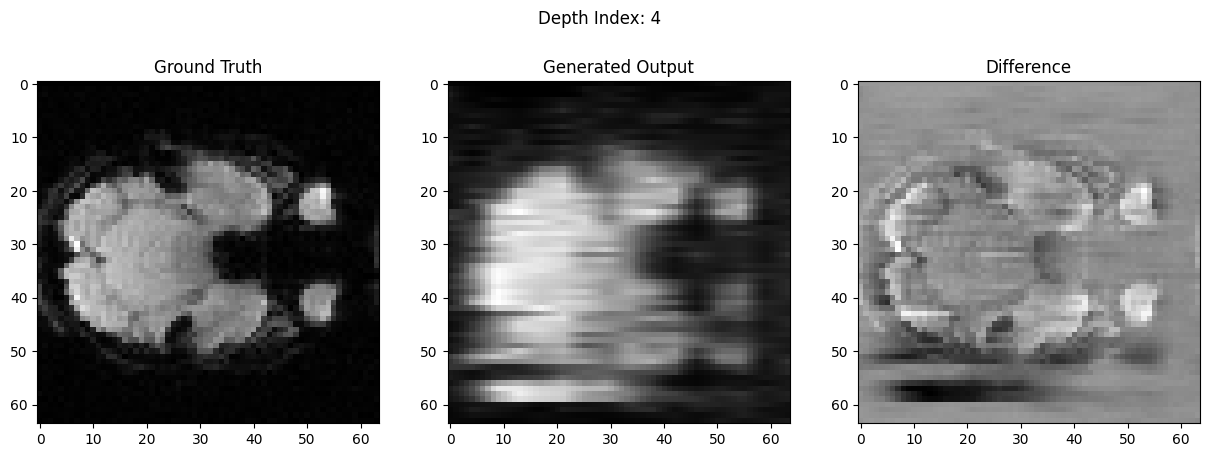

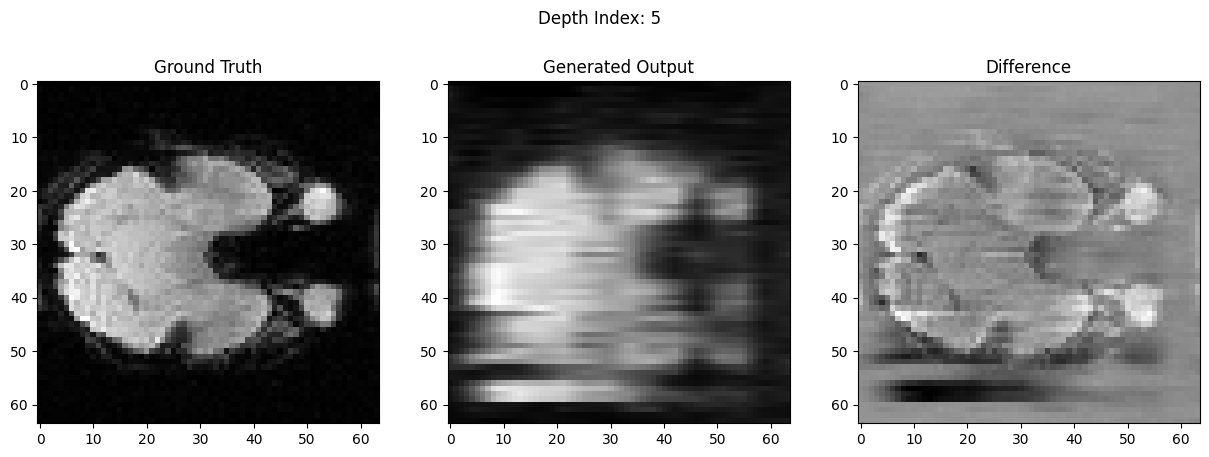

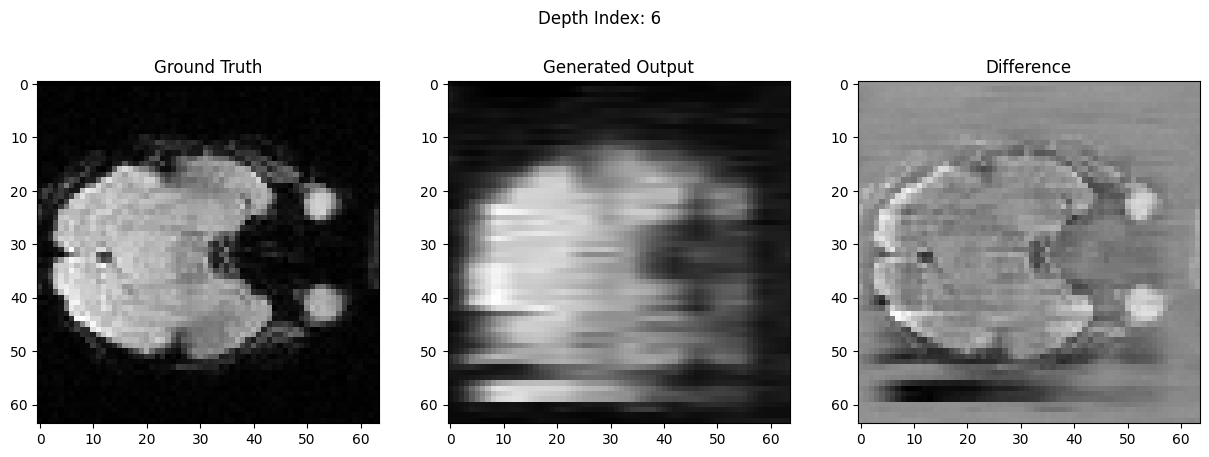

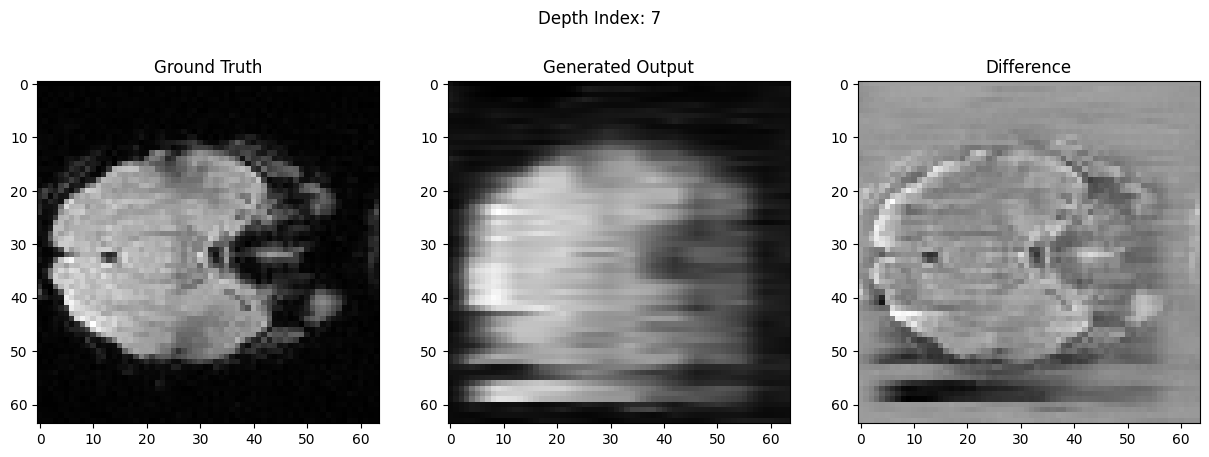

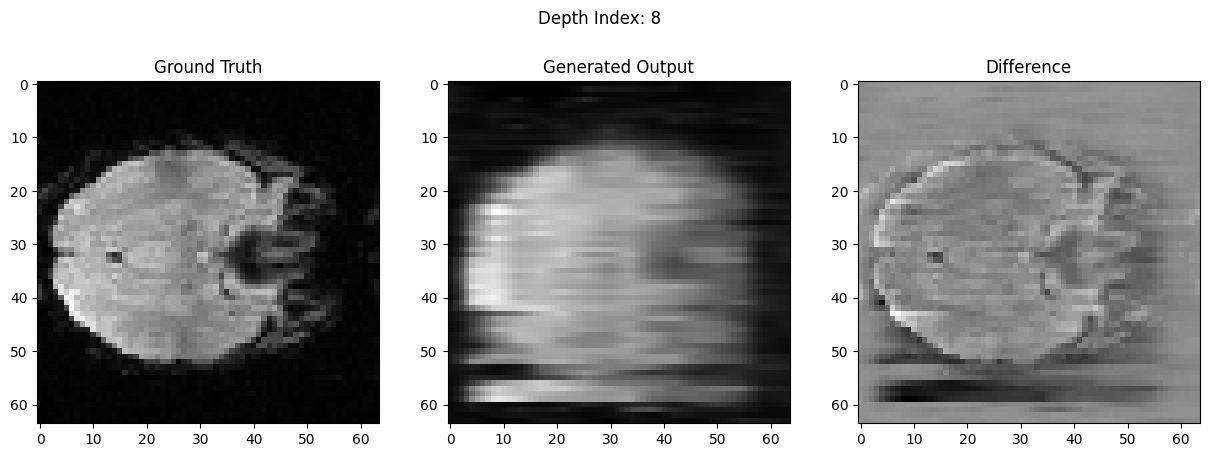

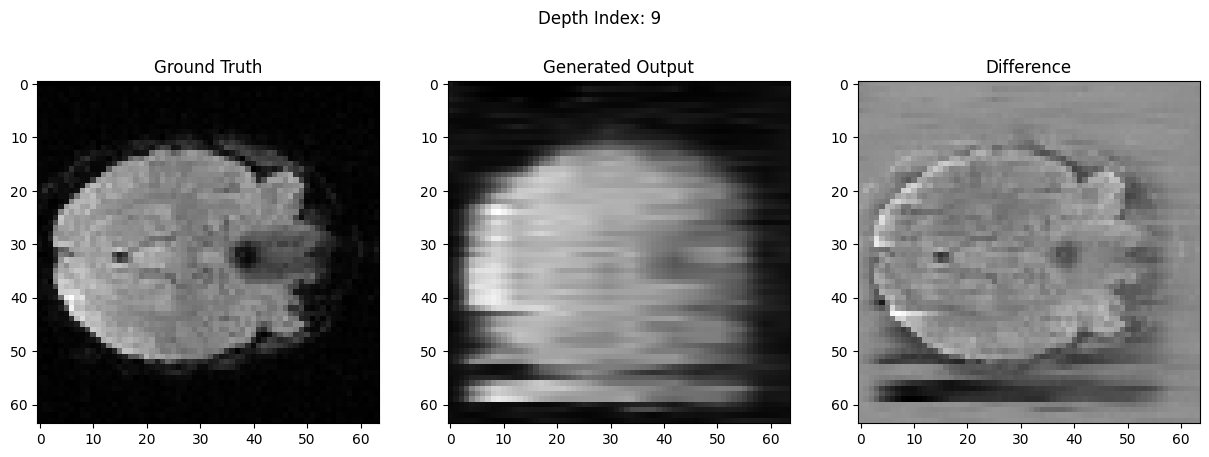

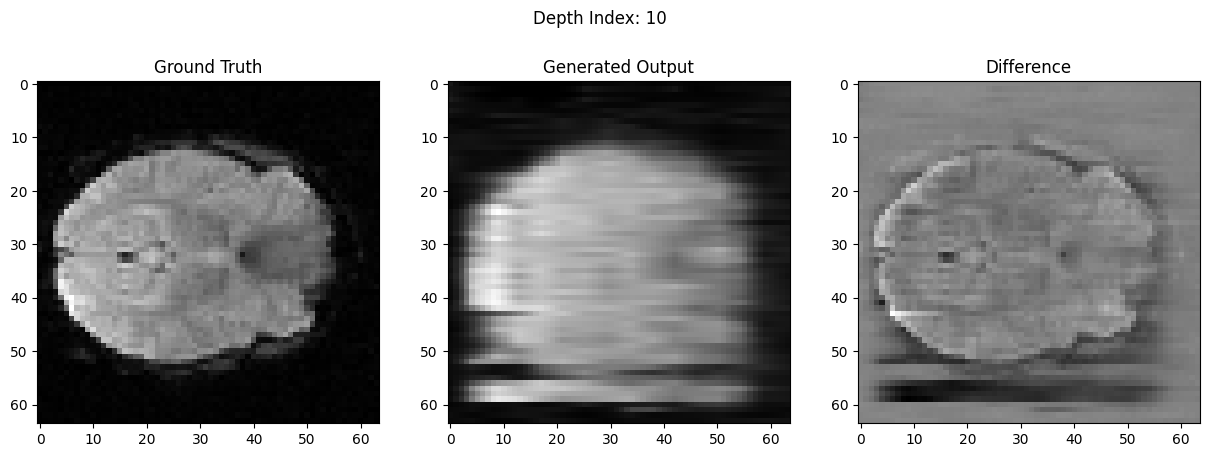

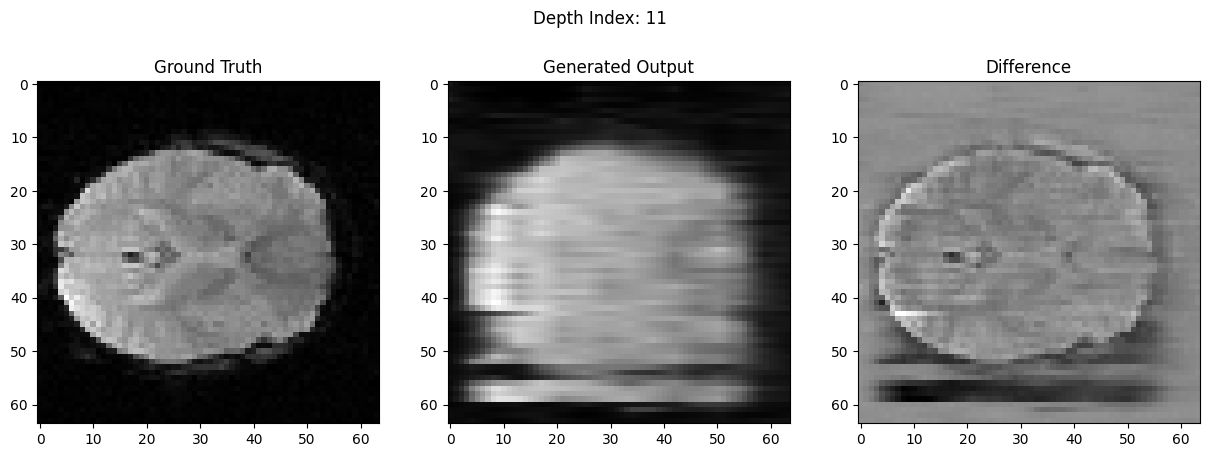

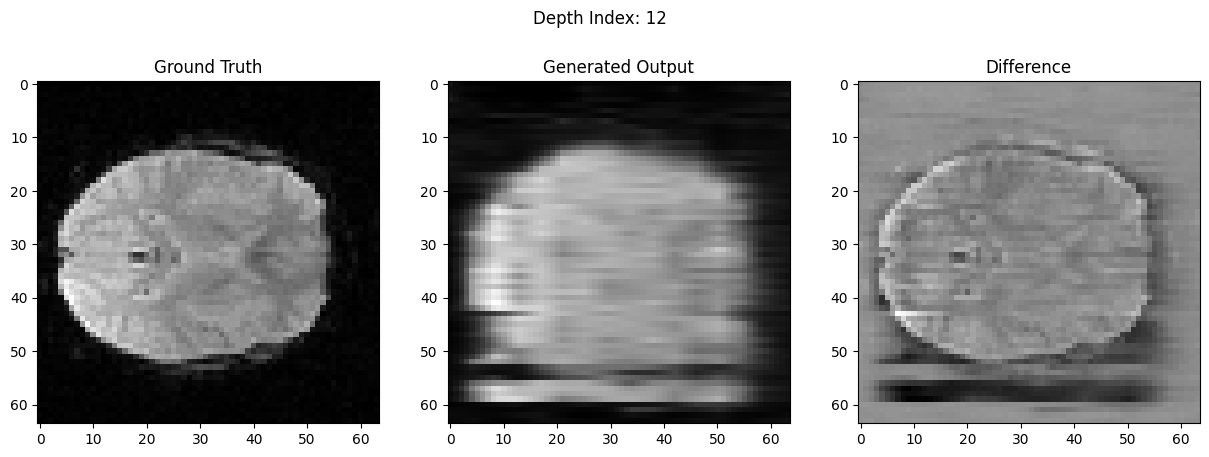

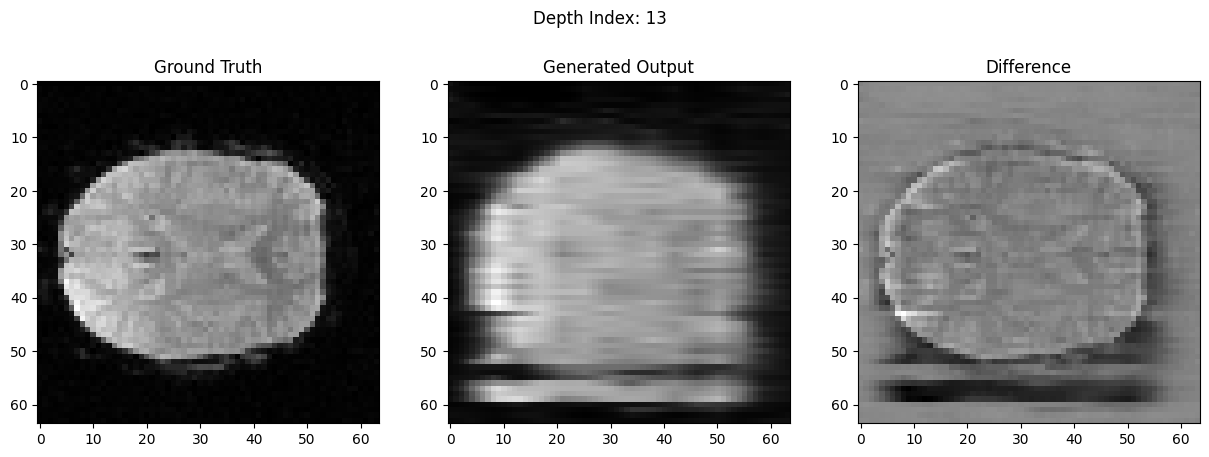

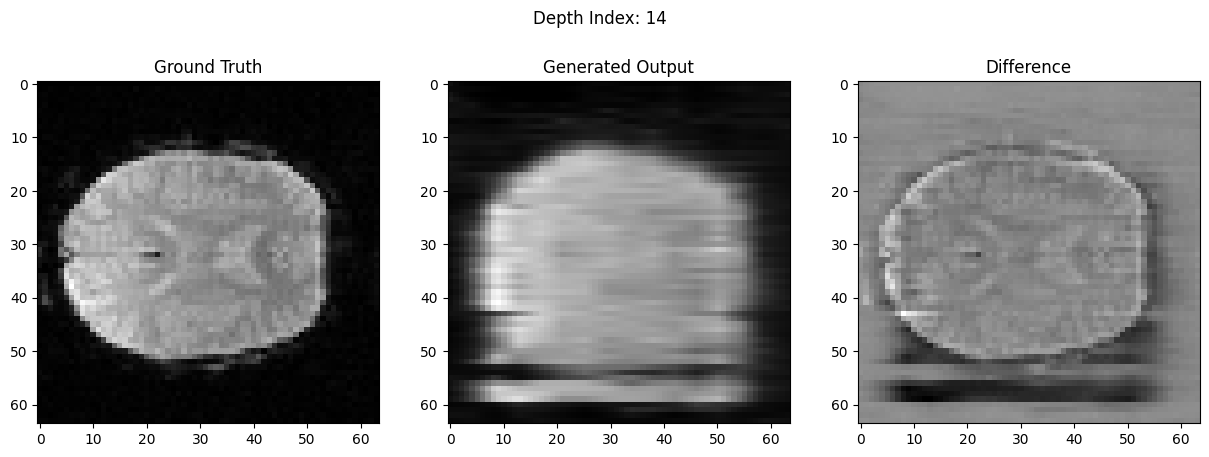

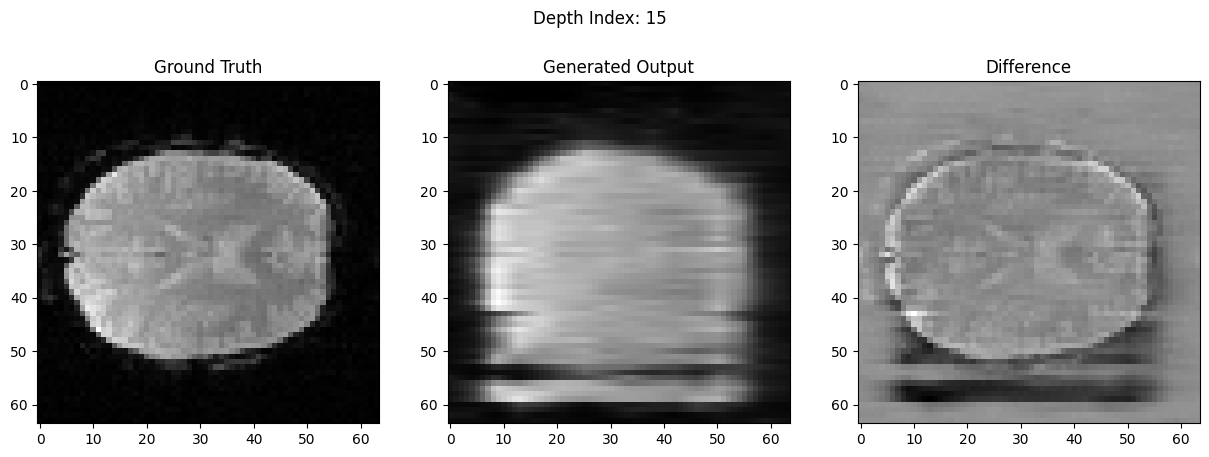

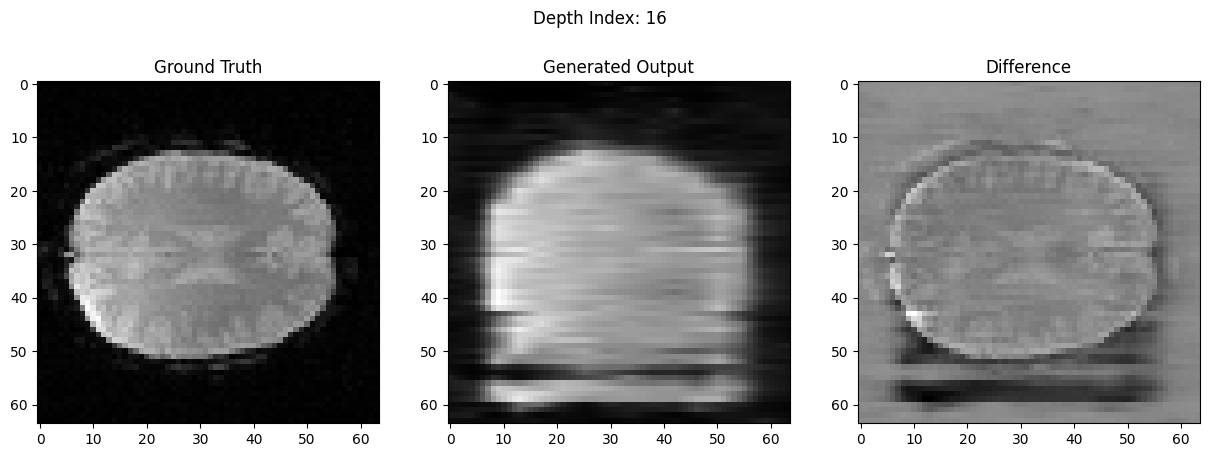

In [16]:
# Function to plot the data
def plot_comparison(labels, outputs, slice_idx):
    for depth_idx in range(17):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Select a specific depth slice
        labels_slice = labels[slice_idx, 0, :, :, depth_idx]
        outputs_slice = outputs[slice_idx, 0, :, :, depth_idx]
        diff_slice = labels_slice - outputs_slice

        # Ensure the selected slices are 2D
        labels_slice = labels_slice if labels_slice.ndim == 2 else labels_slice[:, :, 0]
        outputs_slice = outputs_slice if outputs_slice.ndim == 2 else outputs_slice[:, :, 0]
        diff_slice = diff_slice if diff_slice.ndim == 2 else diff_slice[:, :, 0]

        axes[0].imshow(labels_slice, cmap='gray')
        axes[0].set_title('Ground Truth')

        axes[1].imshow(outputs_slice, cmap='gray')
        axes[1].set_title('Generated Output')

        axes[2].imshow(diff_slice, cmap='gray')
        axes[2].set_title('Difference')

        plt.suptitle(f'Depth Index: {depth_idx}')
        plt.show()

# Plot a comparison for a specific slice and all depths in range 16
plot_comparison(labels_np, outputs_np, slice_idx=0)


In [1]:
!nvidia-smi

Thu Jun 20 15:59:23 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3E:00.0 Off |                    0 |
| N/A   37C    P0    45W / 300W |      3MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------